In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 전체 문장 내 길이 분포 확인

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 지정길이만큼 자르고 부족한 부분은 PAD 넣기

In [6]:
import numpy as np
import tensorflow as tf
import os

In [7]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)


(146182, 41)


In [8]:
print(len(word_to_index))

10000


In [9]:
vocab_size = len(word_to_index)   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### train, validation, test dataset으로 나누기

In [10]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

#(15000, 580)
#(15000,)

(136182, 41)
(136182,)


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 4ms/step - loss: 0.5595 - accuracy: 0.7647 - val_loss: 0.3986 - val_accuracy: 0.8244
Epoch 2/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3638 - accuracy: 0.8433 - val_loss: 0.3522 - val_accuracy: 0.8418
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3214 - accuracy: 0.8640 - val_loss: 0.3451 - val_accuracy: 0.8451
Epoch 4/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2964 - accuracy: 0.8764 - val_loss: 0.3456 - val_accuracy: 0.8472
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2776 - accuracy: 0.8852 - val_loss: 0.3512 - val_accuracy: 0.8465
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2627 - accuracy: 0.8922 - val_loss: 0.3555 - val_accuracy: 0.8464
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2494 - accuracy: 0.8985 - val_loss: 0.3632 - val_accuracy: 0.8448
Epoch 

In [12]:
# 모델 테스트셋 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)


1537/1537 - 2s - loss: 0.5099 - accuracy: 0.8253
[0.5099455118179321, 0.8252741098403931]


In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


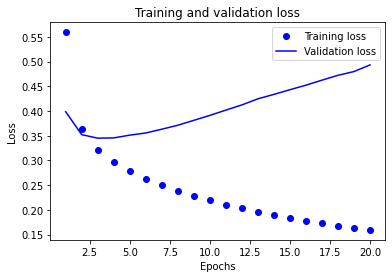

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

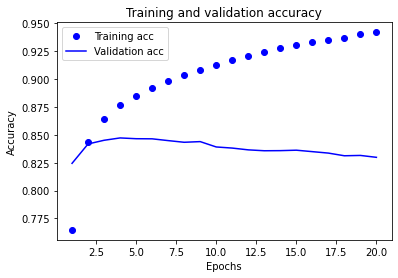

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Embedding 레이어 분석

train dats를 이요하여 학습된 model에 test set에 얼만큼 예측하는지 확인하기 위해 validation dataset을 사용한다,
GolbalMaxPooling으로 모델 학습 결과 loss는 위의 train loss, validation loss 그래프로 확인한 결과 학습이 진행하면서 epoch 수 , 학습이 진행될수록 train loss는 점차 떨어지고 있지만 validation loss는 약, 4 epoch 기점부터 점차 올라가고 있다.
이는 4epoch 이후부터 학습모델의 정확도가 떨어진다는 것을 뜻하기 때문에 2.5epoch에서 학습을 종료하는 것이 좋다. 

### 이전 vocab 저장하기

In [16]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    


(10000, 16)


In [17]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/mnrs_vocab.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### 한국어 word2vec 사용하기

In [18]:
from gensim.models import Word2Vec 

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin.gz'

word2vec= Word2Vec.load(word2vec_file_path)
vector = word2vec['안녕']
vector

/tmp/ipykernel_326/957913031.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['안녕']


array([-4.48758937e-02, -5.26038110e-01,  2.18058324e+00, -2.70098805e-01,
       -1.22612631e+00, -4.35174644e-01,  8.78038049e-01,  1.78903091e+00,
        5.13344407e-01,  8.00866067e-01,  1.33781850e-01,  4.23676372e-01,
        6.25718057e-01, -1.49838462e-01, -2.65716583e-01, -1.18363452e+00,
        1.09828494e-01,  6.56335890e-01,  9.90437388e-01, -2.88908720e-01,
       -4.82253104e-01, -1.71825096e-01, -5.22048175e-01, -1.37081638e-01,
        4.01715070e-01, -3.54384005e-01, -4.38563734e-01,  3.37939188e-02,
       -4.21380460e-01, -2.11324722e-01,  5.34786046e-01,  5.26668072e-01,
       -3.78847629e-01, -1.59311071e-01,  1.77993524e+00, -1.28354877e-01,
        4.53990996e-01,  6.38647795e-01,  3.22042465e-01, -6.49676397e-02,
       -9.30086493e-01,  6.84082747e-01, -1.41875729e-01, -1.49376774e+00,
        1.44657120e-03,  4.33810472e-01, -7.31874406e-02,  7.40463585e-02,
       -6.44519210e-01,  1.11461449e+00, -8.20367783e-02, -5.76601565e-01,
        1.71026981e+00,  

In [19]:
vector.shape

(200,)

In [20]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("안녕")

/tmp/ipykernel_326/3387805902.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("안녕")


[('절망', 0.5654082298278809),
 ('이여', 0.5418729782104492),
 ('청춘', 0.49956801533699036),
 ('첫사랑', 0.49405190348625183),
 ('이별', 0.4899892210960388),
 ('슬픔', 0.48582565784454346),
 ('추억', 0.4816262125968933),
 ('사랑', 0.4783991873264313),
 ('내일', 0.4614541232585907),
 ('!', 0.4595344662666321)]

In [21]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
embedding_matrix 

/tmp/ipykernel_326/1744403119.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_326/1744403119.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


array([[ 0.44695889,  0.91422811,  0.88545664, ...,  0.29751188,
         0.51114104,  0.97789905],
       [ 0.64557758,  0.66046672,  0.20483052, ...,  0.61296735,
         0.41105421,  0.87233198],
       [ 0.07532777,  0.53252606,  0.40610265, ...,  0.53801438,
         0.61282087,  0.18685755],
       ...,
       [ 0.89055559,  0.85743578,  0.16776902, ...,  0.43180669,
         0.48365898,  0.15591538],
       [ 0.50334098,  0.26781677,  0.77910807, ...,  0.90365462,
         0.14484213,  0.68127313],
       [-0.03863803, -0.02460025, -0.09781383, ...,  0.35326836,
         0.07444336, -0.5905953 ]])

In [22]:
embedding_matrix.shape

(10000, 200)

In [45]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
______________________

In [48]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3
batch_size = 4
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)



Epoch 1/3
34046/34046 [==============================] - 116s 3ms/step - loss: 0.2889 - accuracy: 0.8815 - val_loss: 0.3456 - val_accuracy: 0.8501
Epoch 2/3
34046/34046 [==============================] - 114s 3ms/step - loss: 0.2766 - accuracy: 0.8878 - val_loss: 0.3444 - val_accuracy: 0.8548
Epoch 3/3
34046/34046 [==============================] - 114s 3ms/step - loss: 0.2664 - accuracy: 0.8932 - val_loss: 0.3432 - val_accuracy: 0.8533


In [49]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3535 - accuracy: 0.8506
[0.3534572720527649, 0.8506418466567993]
